In [1]:
import sys, os

sys.path += ["../../"]

import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import (
    AcadosOcp,
    AcadosSim,
    AcadosSimSolver,
    AcadosOcpSolver,
    AcadosOcpOptions,
)
import matplotlib.pyplot as plt
import torch
import gpytorch

# zoRO imports
from zero_order_gpmpc.controllers import ZoroAcados
from inverted_pendulum_model_acados import (
    export_simplependulum_ode_model,
    export_ocp_nominal,
)
from utils import base_plot, add_plot_trajectory, EllipsoidTubeData2D

# gpytorch_utils
from gpytorch_utils.gp_hyperparam_training import (
    generate_train_inputs_zoro,
    generate_train_outputs_at_inputs,
    train_gp_model,
)
from gpytorch_utils.gp_utils import (
    gp_data_from_model_and_path,
    gp_derivative_data_from_model_and_path,
    plot_gp_data,
    generate_grid_points,
)
from zero_order_gpmpc.models.gpytorch_models.gpytorch_gp import (
    BatchIndependentMultitaskGPModel,
)


## Define model parameters

We model the inverted pendulum

$$
\dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
$$

which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position ($(\theta_r, \dot{\theta}_r) = (0,0)$), subject to the constraints that overshoot should be avoided, i.e.,

$$
\theta_{lb} \leq \theta \leq \theta_{ub}.
$$

The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

In [2]:
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1


## Set up nominal solver

In [3]:
ocp_init = export_ocp_nominal(N, T, only_lower_bounds=True)
ocp_init.solver_options.nlp_solver_type = "SQP"

acados_ocp_init_solver = AcadosOcpSolver(
    ocp_init, json_file="acados_ocp_init_simplependulum_ode.json"
)

rm -f libacados_ocp_solver_simplependulum_ode.so
rm -f simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun.o acados_solver_simplependulum_ode.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-

## Open-loop planning with nominal solver

In [4]:
# get initial values
X_init = np.zeros((N + 1, nx))
U_init = np.zeros((N, nu))

# xcurrent = x0
X_init[0, :] = x0

# solve
status_init = acados_ocp_init_solver.solve()

if status_init != 0:
    raise Exception(
        "acados acados_ocp_solver returned status {}. Exiting.".format(status_init)
    )

# get data
for i in range(N):
    X_init[i, :] = acados_ocp_init_solver.get(i, "x")
    U_init[i, :] = acados_ocp_init_solver.get(i, "u")

X_init[N, :] = acados_ocp_init_solver.get(N, "x")

## Simulation results (nominal)

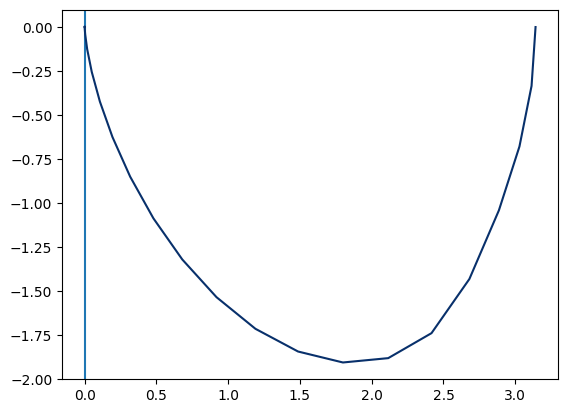

In [5]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(center_data=X_init, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None)

## Robustify simulation

Now we consider the inverted pendulum subject to process noise, i.e., after discretization,

$$
x_{k+1} = F(x_k, u_k) + w_k,
$$

where $w_k \sim \mathcal{N}(0, \Sigma_w)$ denotes process noise and we jhave a potentially nois initial condition $x_0 \sim \mathcal{N}(0, \Sigma_{x0})$ (defined below). Constraints should now be satisfied with satisfaction probability $p_x$, i.e.,

$$
\mathrm{Pr}(h(x,u) \leq 0) \geq p_x.
$$

Note that currently zoRO only accepts upper bounds, i.e., we need to reformulate the nominal constraints $\theta \leq \theta_{ub}$, $-\theta \leq -\theta_{lb}$.
Afterwards, we consider the tightened constraints

$$
h(x,u) + \alpha \sqrt{C(x,u) P C(x,u)} \leq 0,
$$

see problem definition https://www.sciencedirect.com/science/article/pii/S0947358023000912, eq. (9).

In [6]:
# satisfaction probability for chance constraints
prob_x = 0.9
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001 / 360.0) * 2 * np.pi
sigma_omega = (0.0001 / 360.0) * 2 * np.pi
w_theta = 0.03
w_omega = 0.03
Sigma_x0 = np.array([[sigma_theta**2, 0], [0, sigma_omega**2]])
Sigma_W = np.array([[w_theta**2, 0], [0, w_omega**2]])

### Nominal OCP with lower bounds

In [7]:
# without gp model
ocp_zoro_nogp = export_ocp_nominal(N, T, only_lower_bounds=True)

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_zoro_nogp.solver_options.integrator_type = "DISCRETE"
ocp_zoro_nogp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
ocp_zoro_nogp.solver_options.hessian_approx = "GAUSS_NEWTON"
ocp_zoro_nogp.solver_options.nlp_solver_type = "SQP_RTI"

### Nominal model with lower bounds

The tightenings $\sqrt{\ldots}$ can thereby be automatically defined using the `tighten_model_constraints()` function.

In [8]:
# zoro_solver_nogp = ZoroAcados(ocp_zoro_nogp, sim, prob_x, Sigma_x0, Sigma_W+Sigma_GP_prior)
from zero_order_gpmpc.controllers.zoro_acados_utils import (
    generate_h_tightening_funs_SX,
    only_upper_bounds_expr,
    tighten_model_constraints,
)

# make constraints one-sided
ocp_model = export_simplependulum_ode_model(only_lower_bounds=True)

# tighten constraints
idh_tight = np.array([0])  # lower constraint on theta (theta >= 0)

(
    ocp_model_tightened,
    h_jac_x_fun,
    h_tighten_fun,
    h_tighten_jac_x_fun,
    h_tighten_jac_sig_fun,
) = tighten_model_constraints(ocp_model, idh_tight, prob_x)

ocp_zoro_nogp.model = ocp_model_tightened
ocp_zoro_nogp.dims.nh = ocp_model_tightened.con_h_expr.shape[0]
ocp_zoro_nogp.dims.np = ocp_model_tightened.p.shape[0]
ocp_zoro_nogp.parameter_values = np.zeros((ocp_zoro_nogp.dims.np,))

CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc -O3 -fPIC -c jit_tmpa6b1w3.c -o ./tmp_casadi_compiler_shelll19b9j.o"") [.../casadi/solvers/shell_compiler.cpp:232]
CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc ./tmp_casadi_compiler_shelll19b9j.o -o ./tmp_casadi_compiler_shelll19b9j.so -shared"") [.../casadi/solvers/shell_compiler.cpp:251]
CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc -O3 -fPIC -c jit_tmpr1j1no.c -o ./tmp_casadi_compiler_shellrcov2v.o"") [.../casadi/solvers/shell_compiler.cpp:232]
CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc ./tmp_casadi_compiler_shellrcov2v.o -o ./tmp_casadi_compiler_shellrcov2v.so -shared"") [.../casadi/solvers/shell_compiler.cpp:251]
CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc -O3 -fPIC -c jit_tmpboelml.c -o ./tmp_casadi_compiler_shellu6ndau.o"") [.../casadi/solvers/shell_compiler.cpp:232]
CasADi - 2023-12-17 18:47:00 MESSAGE("calling "gcc ./tmp_casadi_compiler_shellu6ndau.o -o ./tmp_casadi_compiler_shellu6ndau.so -shared"") 

## Simulator object

To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

In [9]:
# integrator for nominal model
sim = AcadosSim()

sim.model = ocp_zoro_nogp.model
sim.parameter_values = ocp_zoro_nogp.parameter_values
sim.solver_options.integrator_type = "ERK"

# set prediction horizon
sim.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp_init, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator = AcadosSimSolver(
    sim, json_file="acados_sim_" + sim.model.name + ".json"
)

cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_model/simplependulum_ode_expl_ode_fun.o simplependulum_ode_model/simplependulum_ode_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github

## Create zero-order solver (without GP)

Everything comes together in the `ZoroAcados` constructor:

- nominal OCP `ocp_zoro_nogp`,
- simulator `AcadosSim` object `sim`,
- satisfaction probability `prob_x`,
- initial uncertainty `Sigma_x0`,
- process noise `Sigma_W`,
- Jacobian of tightened constraints w.r.t. covariances $P$, `h_tighten_jac_sig_fun`

In [10]:
# solve with zoRO (no GP model, only process noise)
zoro_solver_nogp = ZoroAcados(
    ocp_zoro_nogp,
    sim,
    prob_x,
    Sigma_x0,
    Sigma_W,
    h_tightening_jac_sig_fun=h_tighten_jac_sig_fun,
)

for i in range(N):
    zoro_solver_nogp.ocp_solver.set(i, "x", X_init[i, :])
    zoro_solver_nogp.ocp_solver.set(i, "u", U_init[i, :])
zoro_solver_nogp.ocp_solver.set(N, "x", X_init[N, :])

zoro_solver_nogp.solve()
X_nogp, U_nogp, P_nogp = zoro_solver_nogp.get_solution()

make: *** No rule to make target 'clean_all'.  Stop.


cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun.o linear_mode

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_ocp_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_ocp_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_ocp_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_ocp_solver_linear_model_with_params_nx2_nu1_np3.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm
rm -f libacados_sim_solver_simplependulum_ode.so
rm -f acados_sim_solver_simplependulum_ode.o
rm -f acados_sim_solver_pyx.so
rm -f acados_sim_solver_pyx.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Reposi

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_sim_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_sim_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_sim_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_sim_solver_simplependulum_ode.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm
residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 3.21205793e-02 4.83118990e-01 1.00000314e-10]
residuals after  1 SQP_RTI iterations:
 [8.38749916e-02 4.19534223e-03 1.18992162e-01 1.00000314e-10]
residuals after  2 SQP_RTI iterations:
 [9.37869947e-03 9.30640585e-05 3.82469371e-02 1.00000314e-10]
residuals after  3 SQP_RTI iterations:
 [2.33955753e-03 9.49541975e-06 2.90535546e-02 1.00000314e-10]
residuals after  4 SQP_RTI iterations:
 [4.82024860e-04 1.52568902e-06 2.52456909e-03 1.00000314e-10]
residuals after  5 SQP_RTI iterations:
 [1.28396356e-05 8.24297398e-09 1.25390800e-03 1.00000314e-10]
residuals afte

### Plot open-loop prediction

Ellipsoids denote the Gaussian confidence intervals, note that one (terminal) ellipsoid "sticks out" since we have omitted the terminal constraint here.

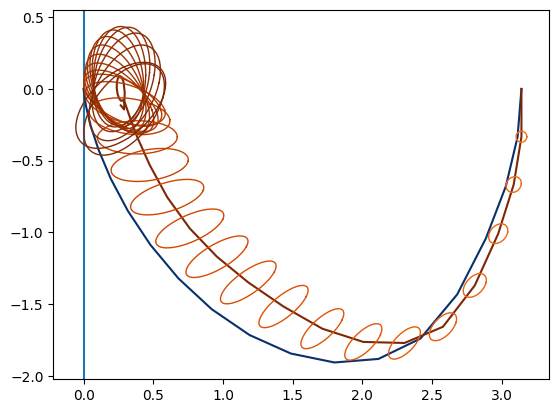

In [11]:
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nogp = EllipsoidTubeData2D(
    center_data=X_nogp,
    ellipsoid_data=np.array(P_nogp),
    # ellipsoid_data = None
)
add_plot_trajectory(
    ax, plot_data_nom, color_fun=plt.cm.Blues, prob_tighten=prob_tighten
)
add_plot_trajectory(
    ax, plot_data_nogp, color_fun=plt.cm.Oranges, prob_tighten=prob_tighten
)

# GP training

We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

In [12]:
# generate training data for GP with augmented model

# "real model"
model_actual = export_simplependulum_ode_model()
model_actual.f_expl_expr = model_actual.f_expl_expr + cas.vertcat(
    cas.DM(0), -0.5 * cas.sin((model_actual.x[0]) ** 2)
)
model_actual.f_impl_expr = model_actual.xdot - model_actual.f_expl_expr
model_actual.name = model_actual.name + "_actual"

# acados integrator
sim_actual = AcadosSim()
sim_actual.model = model_actual
sim_actual.solver_options.integrator_type = "ERK"

# set prediction horizon
sim_actual.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(
    sim_actual, json_file="acados_sim_" + model_actual.name + ".json"
)

cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_actual.o acados_sim_solver_simplependulum_ode_actual.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_actual_model/simplependulum_ode_actual_expl_ode_fun.o simplependulum_ode_actual_model/simplependulum_ode_actual_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/

## Generate training data

We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

In [13]:
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_zoro(
    zoro_solver_nogp,
    x0,
    N_sim_per_x0,
    N_x0,
    random_seed=random_seed,
    x0_rand_scale=x0_rand_scale,
)

y_train = generate_train_outputs_at_inputs(
    x_train, acados_integrator, acados_integrator_actual, Sigma_W
)

residuals after  0 SQP_RTI iterations:
 [3.16675997e-09 4.44089210e-16 4.27721330e-02 1.00000317e-10]
residuals after  1 SQP_RTI iterations:
 [1.81841412e-03 7.39588958e-06 2.66030228e-03 1.00000317e-10]
residuals after  2 SQP_RTI iterations:
 [2.85033004e-04 7.59306090e-08 1.40610077e-03 1.00000317e-10]
residuals after  3 SQP_RTI iterations:
 [7.24845112e-05 7.52988732e-09 8.56199689e-04 1.00000317e-10]
residuals after  4 SQP_RTI iterations:
 [1.48982036e-05 1.23030217e-09 7.01648266e-05 1.00000317e-10]
residuals after  5 SQP_RTI iterations:
 [4.64019626e-07 5.34575162e-12 3.86534306e-05 1.00000317e-10]
residuals after  6 SQP_RTI iterations:
 [3.81938349e-07 3.57899821e-12 5.65328339e-07 1.00000317e-10]
residuals after  0 SQP_RTI iterations:
 [3.61811748e-08 1.11022302e-15 2.02588728e-01 6.54783727e-09]
residuals after  1 SQP_RTI iterations:
 [1.88273708e-02 3.21718618e-04 2.90150871e-02 1.00000309e-10]
residuals after  2 SQP_RTI iterations:
 [2.57363035e-03 6.44205698e-06 1.14193492e

## Hyper-parameter training for GP model

Optimize hyper-parameters of GP model (kernel function parameters, ...)

In [14]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nout)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood)

In [15]:
training_iterations = 500
rng_seed = 456

gp_model, likelihood = train_gp_model(
    gp_model, torch_seed=rng_seed, training_iterations=training_iterations
)

# EVAL MODE
gp_model.eval()
likelihood.eval()

Iter 1/500 - Loss: 1.462
Iter 2/500 - Loss: 1.424
Iter 3/500 - Loss: 1.386
Iter 4/500 - Loss: 1.347
Iter 5/500 - Loss: 1.307
Iter 6/500 - Loss: 1.267
Iter 7/500 - Loss: 1.225
Iter 8/500 - Loss: 1.184
Iter 9/500 - Loss: 1.141
Iter 10/500 - Loss: 1.098
Iter 11/500 - Loss: 1.054
Iter 12/500 - Loss: 1.010
Iter 13/500 - Loss: 0.964
Iter 14/500 - Loss: 0.919
Iter 15/500 - Loss: 0.873
Iter 16/500 - Loss: 0.826
Iter 17/500 - Loss: 0.779
Iter 18/500 - Loss: 0.731
Iter 19/500 - Loss: 0.683
Iter 20/500 - Loss: 0.635
Iter 21/500 - Loss: 0.586
Iter 22/500 - Loss: 0.536
Iter 23/500 - Loss: 0.487
Iter 24/500 - Loss: 0.437
Iter 25/500 - Loss: 0.387
Iter 26/500 - Loss: 0.336
Iter 27/500 - Loss: 0.286
Iter 28/500 - Loss: 0.235
Iter 29/500 - Loss: 0.184
Iter 30/500 - Loss: 0.133
Iter 31/500 - Loss: 0.082
Iter 32/500 - Loss: 0.030
Iter 33/500 - Loss: -0.021
Iter 34/500 - Loss: -0.073
Iter 35/500 - Loss: -0.124
Iter 36/500 - Loss: -0.176
Iter 37/500 - Loss: -0.227
Iter 38/500 - Loss: -0.278
Iter 39/500 - L

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

## Plot GP predictions

We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

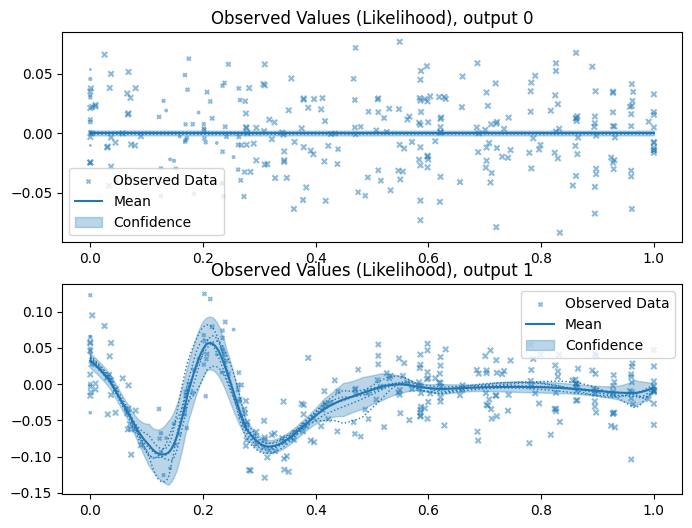

In [16]:
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0, 1, num_points_between_samples, endpoint=False)

x_plot_waypts = np.hstack((X_nogp[1:, :], U_nogp))
x_plot = []
for i in range(x_plot_waypts.shape[0] - 1):
    x_plot += [
        x_plot_waypts[i, :] + (x_plot_waypts[i + 1, :] - x_plot_waypts[i, :]) * t
        for t in t_lin
    ]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood
)
plot_gp_data([gp_data], marker_size_lim=[1, 15])

We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

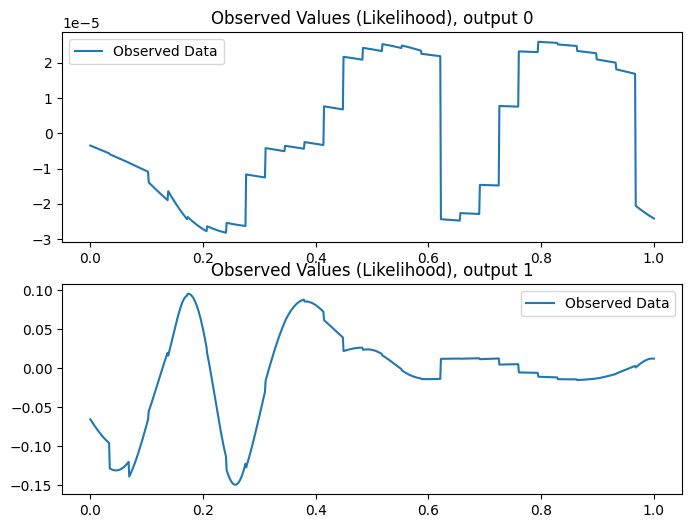

In [17]:
gp_derivative_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=0
)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)

Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

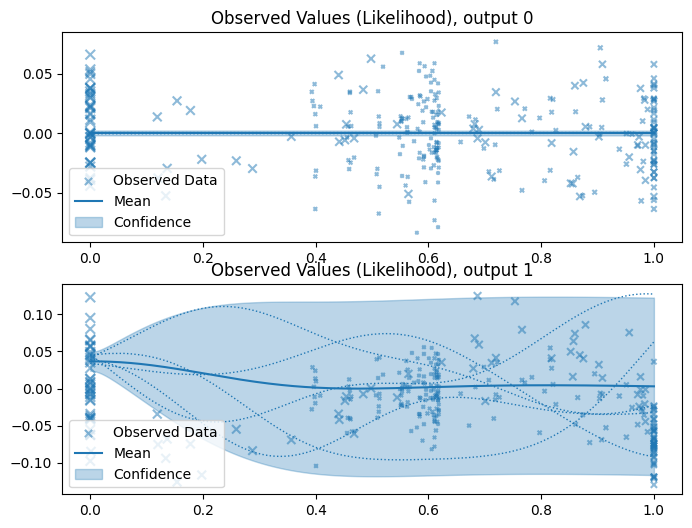

In [18]:
# plot along axis
x_dim_lims = np.array([[0, np.pi], [-2, 1], [-2, 2]])
x_dim_slice = np.array([1 * np.pi, 0, 0])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood
)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()

Jacobian... not much going on away from the data points (this is good!)

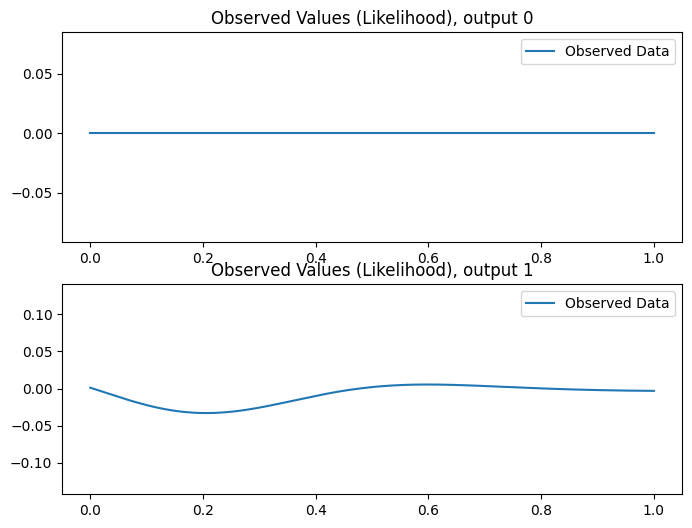

In [19]:
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=0
)
fig, ax = plot_gp_data(
    [gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False
)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()

# Zero-Order GP-MPC

We can add the GP model to the solver by simply adding it as an argument to the `ZoroAcados` function. Therefore we copy (important!) the robustified controller and then instantiate another solver object.

In [20]:
from copy import deepcopy

ocp_zoro = deepcopy(ocp_zoro_nogp)

zoro_solver = ZoroAcados(
    ocp_zoro,
    sim,
    prob_x,
    Sigma_x0,
    Sigma_W,
    h_tightening_jac_sig_fun=h_tighten_jac_sig_fun,
    gp_model=gp_model,
)

for i in range(N):
    zoro_solver.ocp_solver.set(i, "x", X_init[i, :])
    zoro_solver.ocp_solver.set(i, "u", U_init[i, :])
zoro_solver.ocp_solver.set(N, "x", X_init[N, :])

zoro_solver.solve()
X, U, P = zoro_solver.get_solution()

make: *** No rule to make target 'clean_all'.  Stop.


cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun.o linear_mode

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_ocp_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_ocp_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_ocp_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_ocp_solver_linear_model_with_params_nx2_nu1_np3.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm
rm -f libacados_sim_solver_simplependulum_ode.so
rm -f acados_sim_solver_simplependulum_ode.o
rm -f acados_sim_solver_pyx.so
rm -f acados_sim_solver_pyx.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Reposi

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_sim_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_sim_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_sim_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_sim_solver_simplependulum_ode.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm
residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 9.91328558e-02 8.71981741e-01 5.80580558e-09]
residuals after  1 SQP_RTI iterations:
 [6.09966295e-01 3.12531327e-02 4.46795179e-01 4.44134262e-10]
residuals after  2 SQP_RTI iterations:
 [1.28942709e-01 3.50169720e-03 4.38612082e-01 1.00000314e-10]


/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


residuals after  3 SQP_RTI iterations:
 [2.06765708e-02 2.01143370e-03 3.06693562e-01 5.99715239e-10]
residuals after  4 SQP_RTI iterations:
 [2.10732362e-02 7.26269141e-04 8.57874204e-02 1.00000314e-10]
residuals after  5 SQP_RTI iterations:
 [1.21508873e-02 5.71045591e-05 2.35750270e-02 1.00000314e-10]
residuals after  6 SQP_RTI iterations:
 [4.78374637e-03 1.64854953e-05 2.48067116e-02 5.13306622e-09]
residuals after  7 SQP_RTI iterations:
 [3.96613218e-03 1.16124016e-05 1.03343624e-02 8.18464428e-10]
residuals after  8 SQP_RTI iterations:
 [2.07190064e-03 3.62481316e-06 6.33942272e-03 2.65578368e-10]
residuals after  9 SQP_RTI iterations:
 [1.28247768e-03 1.20784595e-06 4.38575824e-03 3.06827684e-10]
residuals after  10 SQP_RTI iterations:
 [8.91477824e-04 9.42935159e-07 2.55546936e-03 3.51850397e-10]
residuals after  11 SQP_RTI iterations:
 [5.15152424e-04 8.56816769e-07 1.60112978e-03 4.01822918e-10]
residuals after  12 SQP_RTI iterations:
 [3.22962913e-04 1.24102217e-06 1.047347

## Trained GP vs. no GP

Plotting trained GP against no-GP, we see that the GP-MPC controller still has higher uncertainties than the robustified one. This is because the GP covariance, albeit being small where data points are, is *added* to the process noise, i.e., we make the controller even more cautious.

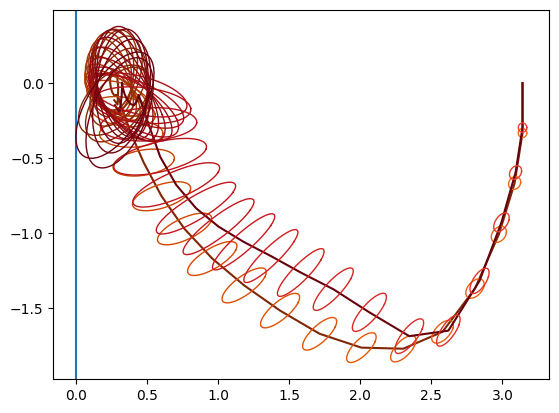

In [21]:
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_gp = EllipsoidTubeData2D(
    center_data=X,
    ellipsoid_data=np.array(P),
    # ellipsoid_data = None
)
add_plot_trajectory(ax, plot_data_nogp, color_fun=plt.cm.Oranges)
add_plot_trajectory(ax, plot_data_gp, color_fun=plt.cm.Reds)

We can get a more insightful comparison by comparing the *conditioned* GP (i.e., with optimized hyper-parameters and data), to the *unconditioned* GP (i.e., with the same, optimized hyper-parameters and no data).

As you can see, the hyper-parameter optimization also provides us with an estimate of the measurement noise for the data points, which corersponds to added process noise in our model (epistemic uncertainty).

In [22]:
ocp_zoro_gpprior = deepcopy(ocp_zoro_nogp)

gp_model.eval()
y_test = torch.Tensor(np.array([[1, 1, 1]]))
Sigma_GP_prior = gp_model.covar_module(y_test).numpy()

Sigma_GP_prior = np.diag(Sigma_GP_prior.flatten())
Sigma_GP_prior

array([[3.8452404e-07, 0.0000000e+00],
       [0.0000000e+00, 3.5683943e-03]], dtype=float32)

In [23]:
Sigma_W

array([[0.0009, 0.    ],
       [0.    , 0.0009]])

Especially in the velocity component, this really makes a difference!

In [24]:
Sigma_W + Sigma_GP_prior

array([[0.00090038, 0.        ],
       [0.        , 0.00446839]])

Now we solve again with *unconditioned* GP and compare...

In [25]:
# zoro_solver_gpprior = ZoroAcados(ocp_zoro_gpprior, sim, prob_x, Sigma_x0, Sigma_W+Sigma_GP_prior)
zoro_solver_gpprior = ZoroAcados(
    ocp_zoro_gpprior,
    sim,
    prob_x,
    Sigma_x0,
    Sigma_W + Sigma_GP_prior,
    h_tightening_jac_sig_fun=h_tighten_jac_sig_fun,
)

for i in range(N):
    zoro_solver_gpprior.ocp_solver.set(i, "x", X_init[i, :])
    zoro_solver_gpprior.ocp_solver.set(i, "u", U_init[i, :])
zoro_solver_gpprior.ocp_solver.set(N, "x", X_init[N, :])

make: *** No rule to make target 'clean_all'.  Stop.


cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np3_constraints/linear_model_with_params_nx2_nu1_np3_constr_h_fun.o linear_mode

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_ocp_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_ocp_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_ocp_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_ocp_solver_linear_model_with_params_nx2_nu1_np3.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm
rm -f libacados_sim_solver_simplependulum_ode.so
rm -f acados_sim_solver_simplependulum_ode.o
rm -f acados_sim_solver_pyx.so
rm -f acados_sim_solver_pyx.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Reposi

In file included from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from acados_sim_solver_pyx.c:1195:
/home/amon/.local/share/virtualenvs/zero-order-gp-mpc-github-Y-8U9LdN/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


cc  -shared \
-o acados_sim_solver_pyx.so \
-Wl,-rpath=/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib \
acados_sim_solver_pyx.o \
/home/amon/Repositories/zero-order-gp-mpc-github/examples/inverted_pendulum/c_generated_code/libacados_sim_solver_simplependulum_ode.so \
-L/home/amon/Repositories/zero-order-gp-mpc-github/acados/lib -lacados -lhpipm -lblasfeo -lm


In [26]:
zoro_solver_gpprior.solve()

X_gpprior, U_gpprior, P_gpprior = zoro_solver_gpprior.get_solution()

residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 3.21205793e-02 7.92428274e-01 1.00000314e-10]
residuals after  1 SQP_RTI iterations:
 [1.31344828e-01 7.56712865e-03 4.27737616e-01 5.33819478e-10]
residuals after  2 SQP_RTI iterations:
 [2.24233907e-02 1.02106302e-03 8.55064439e-02 7.48521622e-09]
residuals after  3 SQP_RTI iterations:
 [6.12918558e-03 5.03927334e-05 1.66377590e-01 1.00000314e-10]
residuals after  4 SQP_RTI iterations:
 [2.28949708e-03 4.98961356e-05 2.90277234e-03 5.86360064e-09]
residuals after  5 SQP_RTI iterations:
 [5.19485923e-05 3.03953843e-08 1.27989558e-02 1.00000314e-10]
residuals after  6 SQP_RTI iterations:
 [1.33339965e-04 2.00682074e-07 1.52147729e-03 1.00000314e-10]
residuals after  7 SQP_RTI iterations:
 [1.95088223e-05 3.72051298e-09 5.05875567e-04 1.00000314e-10]
residuals after  8 SQP_RTI iterations:
 [5.71735107e-06 3.69801884e-10 1.53334114e-04 1.00000314e-10]
residuals after  9 SQP_RTI iterations:
 [1.76783814e-06 3.53517493e-11 2.08729239e

## Zero-Order GP-MPC with unconditioned GP vs. conditioned GP

Now we see that the training indeed paid off, and reduced uncertainty where we obtained data, i.e., we can go closer to the boundary while still being cautious.

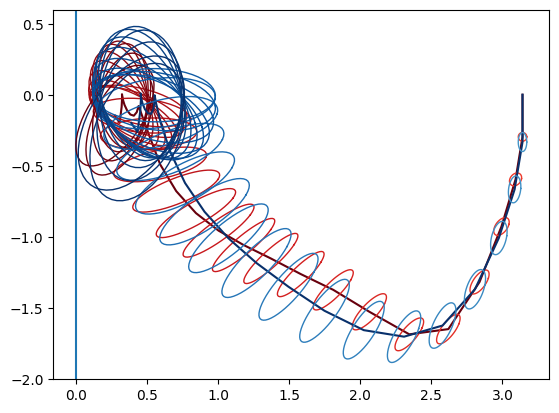

In [27]:

fig, ax = base_plot(lb_theta=lb_theta)

plot_data_gpprior = EllipsoidTubeData2D(
    center_data=X_gpprior,
    ellipsoid_data=np.array(P_gpprior),
    # ellipsoid_data = None
)
add_plot_trajectory(ax, plot_data_gp, color_fun=plt.cm.Reds)
add_plot_trajectory(ax, plot_data_gpprior, color_fun=plt.cm.Blues)